In [53]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

DATA_PATH = "online_shoppers_intention.csv"   
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [54]:
SAMPLE_FOR_SILHOUETTE = 1000   
K_RANGE = range(2, 9)          
N_INIT = 10
RANDOM_STATE = 42

In [55]:
df = pd.read_csv(DATA_PATH)
print("Original rows,cols:", df.shape)
df = df.dropna().reset_index(drop=True)
print("After dropna rows,cols:", df.shape)
display(df.head())

Original rows,cols: (12330, 18)
After dropna rows,cols: (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [56]:
numeric_cols = [c for c in ['Administrative','Administrative_Duration','Informational','Informational_Duration',
                            'ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay'] if c in df.columns]
additional_numeric = [c for c in ['OperatingSystems','Browser','Region','TrafficType'] if c in df.columns]
numeric_cols += additional_numeric


In [57]:
cat_cols = [c for c in ['Month','VisitorType','Weekend'] if c in df.columns]

print("Numeric cols used:", numeric_cols)
print("Categorical (one-hot) cols:", cat_cols)

X_num = df[numeric_cols].copy()

if len(cat_cols) > 0:
    ohe = OneHotEncoder(sparse_output=False, drop='first')  
    X_cat = ohe.fit_transform(df[cat_cols])
    cat_names = ohe.get_feature_names_out(cat_cols)
    X_cat = pd.DataFrame(X_cat, columns=cat_names, index=df.index)
    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
else:
    X = X_num.copy()

print("Final feature matrix shape:", X.shape)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Numeric cols used: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
Categorical (one-hot) cols: ['Month', 'VisitorType', 'Weekend']
Final feature matrix shape: (12330, 26)


In [58]:
rng = np.random.RandomState(RANDOM_STATE)
if X_scaled.shape[0] > SAMPLE_FOR_SILHOUETTE:
    idx = rng.choice(X_scaled.shape[0], SAMPLE_FOR_SILHOUETTE, replace=False)
    X_sample = X_scaled[idx]
else:
    X_sample = X_scaled

Ks = list(K_RANGE)
inertias = []
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=N_INIT, max_iter=300)
    labels = km.fit_predict(X_sample)
    inertias.append(km.inertia_)
    try:
        sil_scores.append(silhouette_score(X_sample, labels))
    except:
        sil_scores.append(np.nan)

Ks tested: [2, 3, 4, 5, 6, 7, 8]
Sampled silhouette scores: {2: 0.20584465150013856, 3: 0.19916623474139322, 4: 0.08587446408117586, 5: 0.09887125315374817, 6: 0.13195076447286017, 7: 0.12501095865845005, 8: 0.1719985775926847}
Chosen k: 2


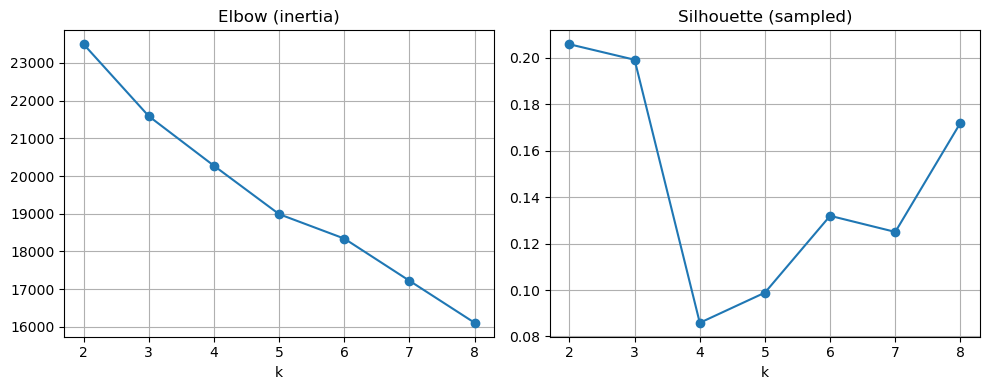

In [59]:
sil_array = np.array(sil_scores, dtype=float)
if np.all(np.isnan(sil_array)):
    best_k = 3
else:
    best_k = Ks[int(np.nanargmax(sil_array))]

print("Ks tested:", Ks)
print("Sampled silhouette scores:", dict(zip(Ks, sil_scores)))
print("Chosen k:", best_k)

# plots: elbow + silhouette
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o'); plt.title('Elbow (inertia)'); plt.xlabel('k'); plt.grid(True)
plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, marker='o'); plt.title('Silhouette (sampled)'); plt.xlabel('k'); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "elbow_silhouette.png"))
plt.show()

In [65]:
final_km = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=N_INIT, max_iter=300)
labels_full = final_km.fit_predict(X_scaled)
df_out = df.copy()
df_out['Cluster'] = labels_full


In [66]:
df_out.to_csv(os.path.join(OUTPUT_DIR, "customers_with_clusters.csv"), index=False)


In [67]:
centers_scaled = final_km.cluster_centers_
centers_unscaled = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_unscaled, columns=X.columns)
centers_df.index.name = 'Cluster'
centers_df.to_csv(os.path.join(OUTPUT_DIR, "cluster_centers.csv"))


In [68]:
cluster_counts = df_out['Cluster'].value_counts().sort_index()
cluster_means = df_out.groupby('Cluster')[numeric_cols].mean()
cluster_summary = cluster_means.copy()
cluster_summary['Count'] = cluster_counts.values
cluster_summary.to_csv(os.path.join(OUTPUT_DIR, "cluster_summary.csv"))

print("Saved outputs to", OUTPUT_DIR)
print("Cluster counts:\n", cluster_counts)


Saved outputs to online_kmeans_output
Cluster counts:
 Cluster
0     1938
1    10392
Name: count, dtype: int64


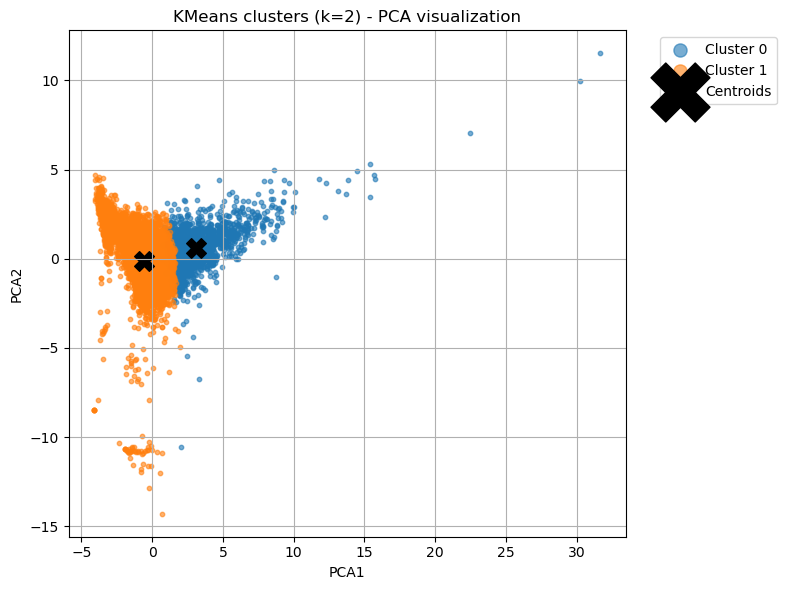

In [69]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in sorted(np.unique(labels_full)):
    mask = labels_full == c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], s=10, alpha=0.6, label=f"Cluster {c}")
centers_pca = pca.transform(centers_scaled)
plt.scatter(centers_pca[:,0], centers_pca[:,1], marker='X', s=200, c='black', label='Centroids')
plt.title(f"KMeans clusters (k={best_k}) - PCA visualization")
plt.xlabel('PCA1'); plt.ylabel('PCA2'); plt.legend(markerscale=3, bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "clusters_pca.png"))
plt.show()